# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [16]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import keras_tuner as kt
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [17]:
# Define a function to load data and aggregate them

def load_and_combine_data(file_list):
    df_list = []
    for file in file_list:
        data = pd.read_csv(file)
        df_list.append(data)
    combined_df = pd.concat(df_list, axis=0)
    return combined_df


In [18]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
file_list = [
    'RNN_Stocks_Data/AMZN_stocks_data.csv',
    'RNN_Stocks_Data/GOOGL_stocks_data.csv',
    'RNN_Stocks_Data/IBM_stocks_data.csv',
    'RNN_Stocks_Data/MSFT_stocks_data.csv'
]
# Load and combine data
combined_data = load_and_combine_data(file_list)

In [19]:
# View specifics of the data
combined_data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [20]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12077 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    12077 non-null  object 
 1   Open    12076 non-null  float64
 2   High    12077 non-null  float64
 3   Low     12076 non-null  float64
 4   Close   12077 non-null  float64
 5   Volume  12077 non-null  int64  
 6   Name    12077 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 754.8+ KB


#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [21]:
# Handle Missing Values

# Check for missing values
print("Missing values before handling:")
print(combined_data.isnull().sum())

Missing values before handling:
Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64


In [22]:
# Drop rows with missing values
combined_data = combined_data.dropna()

# Check again to confirm
print("\nMissing values after handling:")
print(combined_data.isnull().sum())


Missing values after handling:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64


In [23]:
# Ensure 'Date' is in datetime format
combined_data['Date'] = pd.to_datetime(combined_data['Date'])

In [24]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12076 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    12076 non-null  datetime64[ns]
 1   Open    12076 non-null  float64       
 2   High    12076 non-null  float64       
 3   Low     12076 non-null  float64       
 4   Close   12076 non-null  float64       
 5   Volume  12076 non-null  int64         
 6   Name    12076 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 754.8+ KB


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

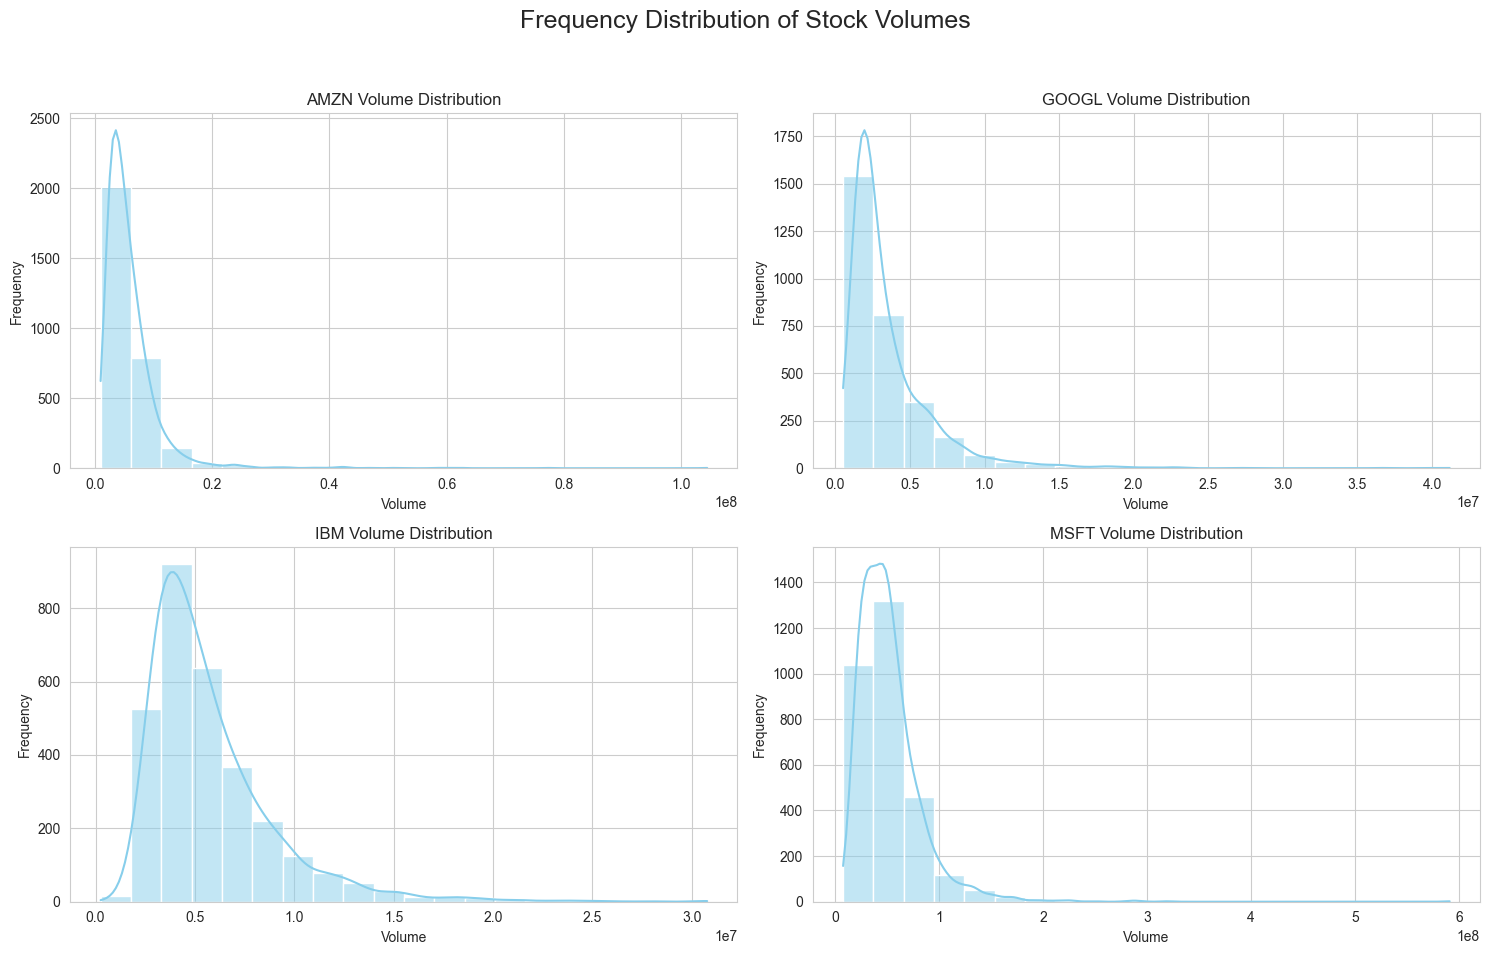

In [25]:
# Frequency distribution of volumes

df = combined_data

# Set plotting style
sns.set_style('whitegrid')
plt.figure(figsize=(15, 10))

plt.suptitle('Frequency Distribution of Stock Volumes', fontsize=18)
for idx, company in enumerate(companies, 1):
    plt.subplot(2, 2, idx)
    sns.histplot(df[df['Name'] == company]['Volume'], bins=20, kde=True, color='skyblue')
    plt.title(f'{company} Volume Distribution')
    plt.xlabel('Volume')
    plt.ylabel('Frequency')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to not overlap title
plt.show()


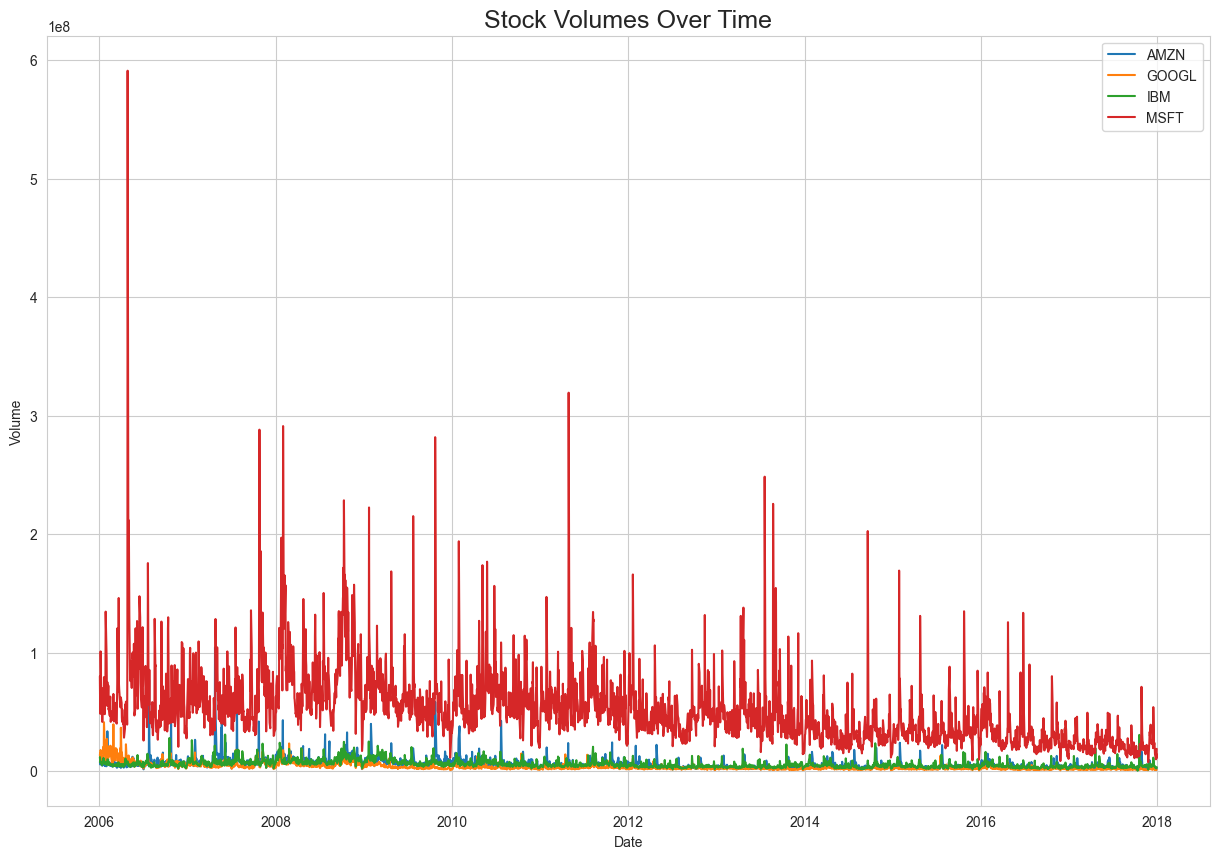

In [26]:
# Stock volume variation over time
plt.figure(figsize=(15, 10))
plt.title('Stock Volumes Over Time', fontsize=18)
for company in companies:
    company_data = df[df['Name'] == company]
    plt.plot(company_data['Date'], company_data['Volume'], label=company)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

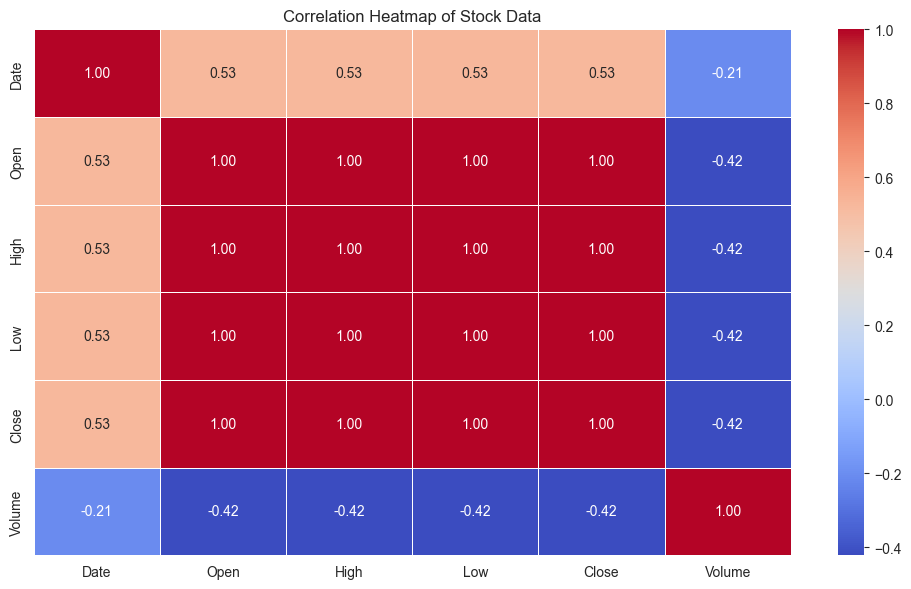

In [27]:
# Analyse correlations

# Dropping the 'Name' column as it's non-numeric and irrelevant for correlation analysis
df_numeric = combined_data.drop(columns=['Name'])

correlation_matrix = df_numeric.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Stock Data')
plt.tight_layout()
plt.show()

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [28]:
# Define a function that divides the data into windows and generates target variable values for each window

def create_windowed_variables(df, window_size=65, step_size=5, target_column='Close'):
    """
    Creates windowed data (X), corresponding target variable (y), and the stock Name.
    """
    X = []
    y = []
    stock_names = []
    
    # Ensure the data is sorted by 'Date'
    df = df.sort_values(by='Date')
    
    for i in range(0, len(df) - window_size, step_size):
        window_data = df.iloc[i:i+window_size]
        
        # Extract the features (drop 'Date', 'Name', and 'target_column')
        X_window = window_data.drop(columns=['Date', 'Name', target_column]).values
        
        # Extract the target (next timestep Close value)
        y_target = df[target_column].iloc[i+window_size]
        
        # Capture the stock name
        stock_name = df['Name'].iloc[i+window_size]
        
        X.append(X_window)
        y.append(y_target)
        stock_names.append(stock_name)
    
    X = np.array(X)
    y = np.array(y)
    stock_names = np.array(stock_names)
    
    return X, y, stock_names

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [29]:
# Define a function that scales the windowed data

# The function takes in the windowed data sets and returns the scaled windows

def scale_windowed_data(X, y):
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # partial_fit on X
    for i in range(X.shape[0]):
        scaler_X.partial_fit(X[i])

    X_scaled = []
    for i in range(X.shape[0]):
        X_scaled.append(scaler_X.transform(X[i]))
    
    X_scaled = np.array(X_scaled)

    # Scale y
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).reshape(-1)

    return X_scaled, y_scaled, scaler_X, scaler_y 

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [30]:
# Define a function to create input and output data points from the master DataFrame

def split_train_test(X, y, stock_names, test_size=0.2, random_state=42):
    """
    Splits X and y into training and testing sets, keeping stock names aligned.

    Args:
    - X: Numpy array of features
    - y: Numpy array of targets
    - stock_names: Numpy array of stock names
    - test_size: Fraction of the data to be used as test set
    - random_state: Random seed for reproducibility

    Returns:
    - Dictionary with stock name as key and (X_train, X_test, y_train, y_test) as value
    """
    results = {}

    unique_stocks = np.unique(stock_names)

    for stock in unique_stocks:
        # Filter data for this stock
        X_stock = X[stock_names == stock]
        y_stock = y[stock_names == stock]

        # Perform train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_stock, y_stock, test_size=test_size, random_state=random_state
        )

        results[stock] = (X_train, X_test, y_train, y_test)

    return results

We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

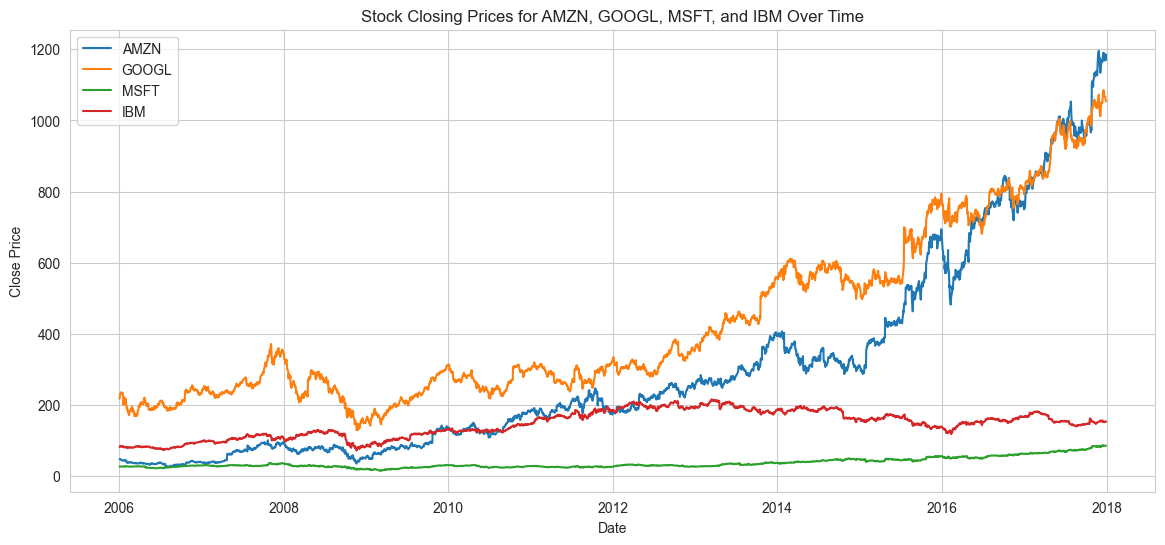

In [31]:
plt.figure(figsize=(14, 6))

# Plotting for AMZN
plt.plot(combined_data[combined_data['Name'] == 'AMZN']['Date'], 
         combined_data[combined_data['Name'] == 'AMZN']['Close'], label='AMZN')

# Plotting for GOOGL
plt.plot(combined_data[combined_data['Name'] == 'GOOGL']['Date'], 
         combined_data[combined_data['Name'] == 'GOOGL']['Close'], label='GOOGL')

# Plotting for MSFT
plt.plot(combined_data[combined_data['Name'] == 'MSFT']['Date'], 
         combined_data[combined_data['Name'] == 'MSFT']['Close'], label='MSFT')

# Plotting for IBM
plt.plot(combined_data[combined_data['Name'] == 'IBM']['Date'], 
         combined_data[combined_data['Name'] == 'IBM']['Close'], label='IBM')

plt.title('Stock Closing Prices for AMZN, GOOGL, MSFT, and IBM Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

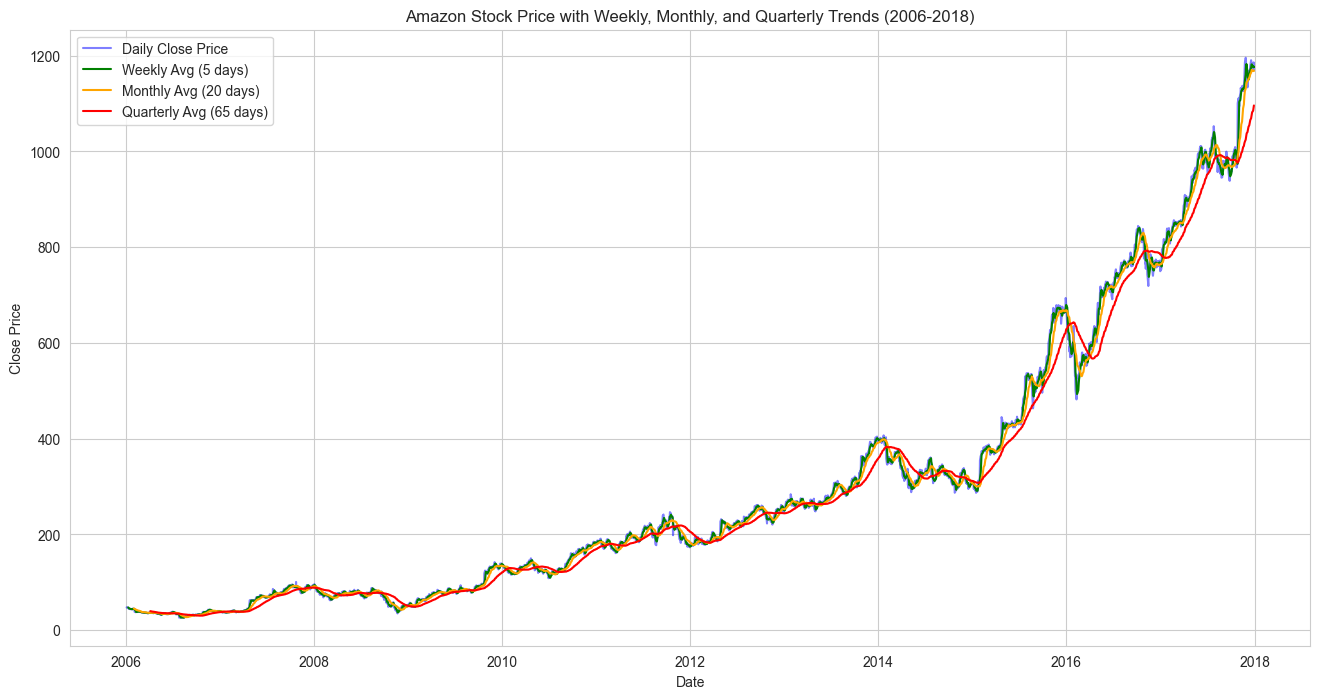

In [32]:
# Checking for patterns in different sequence lengths

plt.figure(figsize=(16, 8))

# Focus on one stock, e.g., Amazon (AMZN)
amzn_df = combined_data[combined_data['Name'] == 'AMZN'].copy()
amzn_df['Date'] = pd.to_datetime(amzn_df['Date'])
amzn_df.set_index('Date', inplace=True)

# Actual daily close price
plt.plot(amzn_df.index, amzn_df['Close'], label='Daily Close Price', color='blue', alpha=0.5)

# 5-day rolling mean (weekly)
plt.plot(amzn_df['Close'].rolling(window=5).mean(), label='Weekly Avg (5 days)', color='green')

# 20-day rolling mean (monthly)
plt.plot(amzn_df['Close'].rolling(window=20).mean(), label='Monthly Avg (20 days)', color='orange')

# 65-day rolling mean (quarterly)
plt.plot(amzn_df['Close'].rolling(window=65).mean(), label='Quarterly Avg (65 days)', color='red')

# Plot formatting
plt.title('Amazon Stock Price with Weekly, Monthly, and Quarterly Trends (2006-2018)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


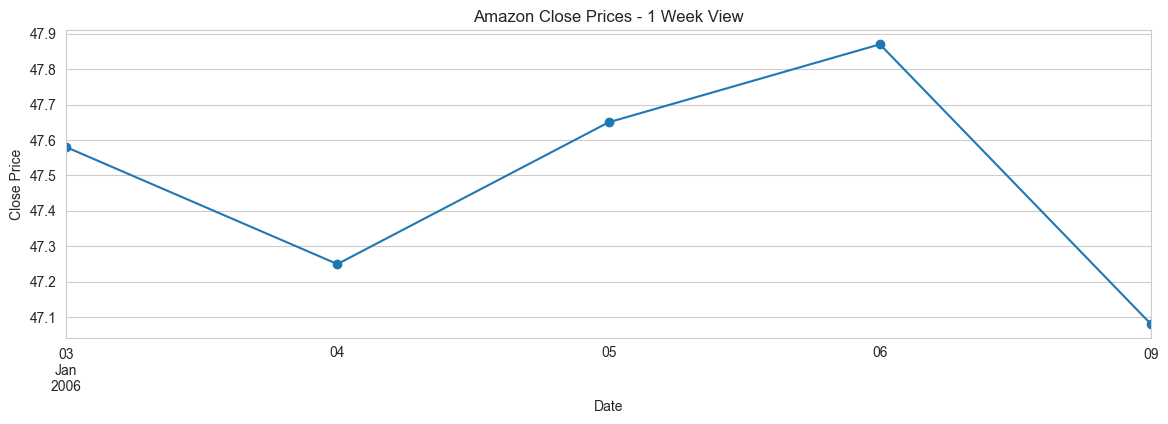

In [33]:
amzn_df = combined_data[combined_data['Name'] == 'AMZN'].set_index('Date')

# Plot 1 Week (first 5 business days)
plt.figure(figsize=(14, 4))
amzn_df['Close'].iloc[:5].plot(marker='o')
plt.title('Amazon Close Prices - 1 Week View')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

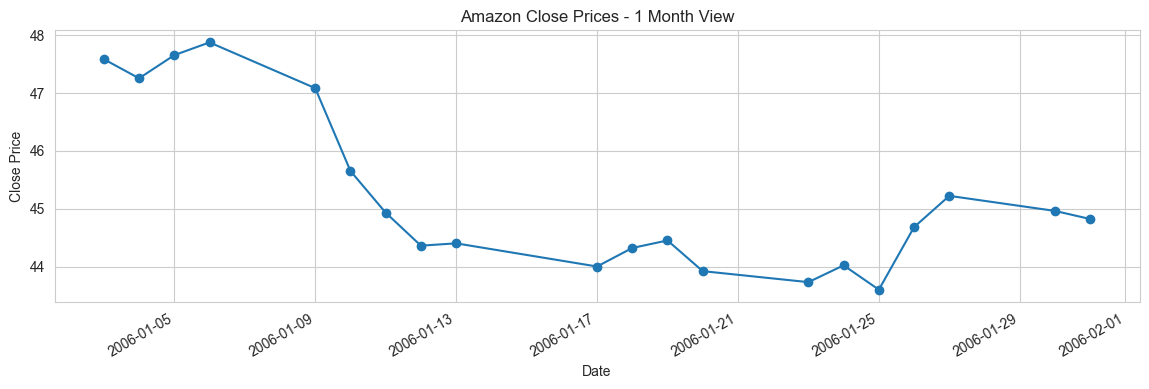

In [34]:
# Plot 1 Month (~20 business days)
plt.figure(figsize=(14, 4))
amzn_df['Close'].iloc[:20].plot(marker='o')
plt.title('Amazon Close Prices - 1 Month View')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

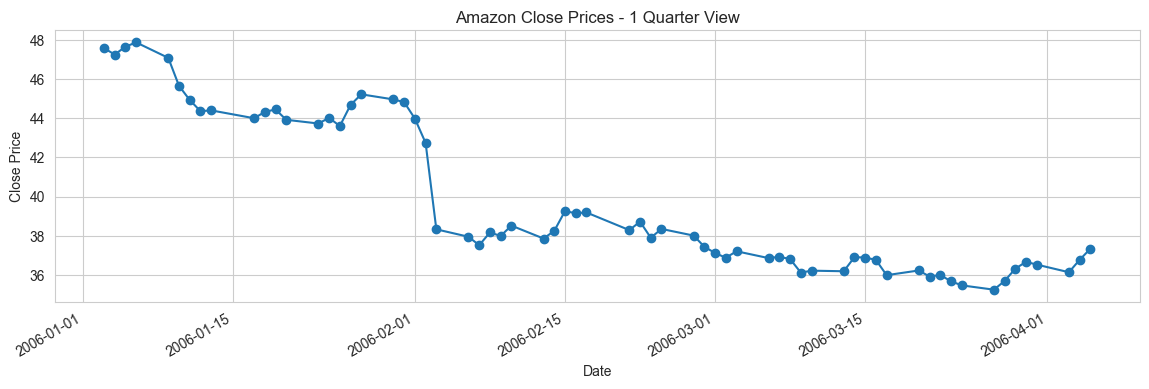

In [35]:
# Plot 1 Quarter (~65 business days)
plt.figure(figsize=(14, 4))
amzn_df['Close'].iloc[:65].plot(marker='o')
plt.title('Amazon Close Prices - 1 Quarter View')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()


##### 1-Week View (5 business days):
- The 1-week view shows very little overall pattern, just small ups and downs — too noisy for a reliable model.

##### 1-Month View (20 business days):
- Still quite noisy.
- Prices fluctuate without forming clear trends.
- Harder for an RNN model to "learn" good patterns reliably.

##### 1-Quarter View (65 business days):
- Clearer trendlines: larger swings, less "random" movement.
- Much more meaningful for a sequential model like RNN or LSTM to pick up trends.

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [36]:
combined_data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [37]:
# Create a pipeline
def prepare_data_pipeline(combined_data, target_names, window_size=65, step_size=5, test_size=0.2):
    """
    Prepares the windowed, scaled, and split data for multiple stocks together.

    Returns:
    - X_train, y_train, stock_train
    - X_test, y_test, stock_test
    """

    X_all = []
    y_all = []
    stock_all = []

    for stock in target_names:
        stock_df = combined_data[combined_data['Name'] == stock]
        
        X_stock, y_stock, stock_labels = create_windowed_variables(
            stock_df, 
            window_size=window_size, 
            step_size=step_size, 
            target_column='Close'
        )
        # Append stock label for each window
        stock_labels = [stock] * len(X_stock)
        
        X_all.append(X_stock)
        y_all.append(y_stock)
        stock_all.extend(stock_labels)

    # Stack all stocks
    X_all = np.vstack(X_all)
    y_all = np.hstack(y_all)
    stock_all = np.array(stock_all)
    
    # Now scale
    X_all_scaled, y_all_scaled, scaler_X, scaler_y = scale_windowed_data(X_all, y_all)
    
    # Train-Test Split (SAME split for all stocks)
    X_train, X_test, y_train, y_test, stock_train, stock_test = train_test_split(
        X_all_scaled, y_all_scaled, stock_all, test_size=test_size, random_state=42, shuffle=True
    )
    
    return X_train, X_test, y_train, y_test, stock_train, stock_test, scaler_X, scaler_y

In [40]:
# Create data instances from the master data frame using decided window size and window stride

# Prepare the data from combined_data
X_train, X_test, y_train, y_test, stock_train, stock_test, scaler_X, scaler_y = prepare_data_pipeline(
    combined_data=combined_data, 
    target_names=['AMZN', 'GOOGL', 'IBM', 'MSFT'], 
    window_size=65, 
    step_size=5, 
    test_size=0.2
)

In [41]:
# Check the number of data points generated
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"stock_train shape: {stock_train.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1891, 65, 4)
y_train shape: (1891,)
stock_train shape: (1891,)
X_test shape: (473, 65, 4)
y_test shape: (473,)


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [25]:
# Check if the datasets are compatible inputs to neural networks


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [42]:
# Create a function that creates a simple RNN model according to the model configuration arguments
def build_model(hp, model_type='SimpleRNN', input_shape=(65, 4)):
    model = Sequential()

    # Add Input layer explicitly
    model.add(Input(shape=input_shape))

    # Add RNN layers
    num_layers = hp.Int('num_layers', 1, 3)  # Tune between 1 to 3 layers
    
    for i in range(num_layers):
        units = hp.Int(f'units_layer_{i}', min_value=32, max_value=256, step=32)
        return_sequences = i < num_layers - 1  # True for intermediate layers
        
        if model_type == 'SimpleRNN':
            model.add(SimpleRNN(units=units, activation='tanh', return_sequences=return_sequences))
        elif model_type == 'LSTM':
            model.add(LSTM(units=units, activation='tanh', return_sequences=return_sequences))
        elif model_type == 'GRU':
            model.add(GRU(units=units, activation='tanh', return_sequences=return_sequences))
                
        dropout_rate = hp.Float(f'dropout_layer_{i}', 0.1, 0.5, step=0.1)
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1))  # Final output
    
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    
    return model

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [45]:
# Find an optimal configuration of simple RNN

# Tuner Setup
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, model_type='SimpleRNN', input_shape=(X_train.shape[1], X_train.shape[2])),
    objective='val_loss',
    max_trials=20,
    executions_per_trial=2,
    directory='rnn_tuning_final',
    project_name='final_rnn_search'
)

# Define EarlyStopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,   # Stop if val_loss doesn't improve for 5 epochs
    restore_best_weights=True
)

In [46]:
# Find the best configuration based on evaluation metrics

tuner.search(
    X_train, y_train, 
    epochs=50, 
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

best_hps = tuner.get_best_hyperparameters(1)[0]

print("\n Best Hyperparameters:")
print(f"Number of Layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"  Layer {i+1} - Units: {best_hps.get(f'units_layer_{i}')}, Dropout: {best_hps.get(f'dropout_layer_{i}')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

Trial 20 Complete [00h 00m 30s]
val_loss: 0.0026234378456138074

Best val_loss So Far: 0.0011443889234215021
Total elapsed time: 00h 33m 49s

 Best Hyperparameters:
Number of Layers: 1
  Layer 1 - Units: 256, Dropout: 0.2
Learning Rate: 0.001


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [47]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

simple_model = tuner.hypermodel.build(best_hps)

simple_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 256)                 │          66,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,073 (262.00 KB)

 Trainable params: 67,073 (262.00 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
history = simple_model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/50
60/60 - 3s - 55ms/step - loss: 0.0847 - mae: 0.1879 - val_loss: 0.0061 - val_mae: 0.0568
Epoch 2/50
60/60 - 2s - 31ms/step - loss: 0.0229 - mae: 0.1065 - val_loss: 0.0120 - val_mae: 0.0845
Epoch 3/50
60/60 - 3s - 44ms/step - loss: 0.0152 - mae: 0.0840 - val_loss: 0.0022 - val_mae: 0.0299
Epoch 4/50
60/60 - 2s - 31ms/step - loss: 0.0114 - mae: 0.0720 - val_loss: 0.0037 - val_mae: 0.0416
Epoch 5/50
60/60 - 3s - 43ms/step - loss: 0.0112 - mae: 0.0702 - val_loss: 0.0042 - val_mae: 0.0452
Epoch 6/50
60/60 - 3s - 43ms/step - loss: 0.0081 - mae: 0.0613 - val_loss: 0.0027 - val_mae: 0.0350
Epoch 7/50
60/60 - 2s - 30ms/step - loss: 0.0085 - mae: 0.0616 - val_loss: 0.0020 - val_mae: 0.0259
Epoch 8/50
60/60 - 2s - 30ms/step - loss: 0.0078 - mae: 0.0577 - val_loss: 0.0018 - val_mae: 0.0256
Epoch 9/50
60/60 - 2s - 30ms/step - loss: 0.0063 - mae: 0.0522 - val_loss: 0.0017 - val_mae: 0.0238
Epoch 10/50
60/60 - 3s - 45ms/step - loss: 0.0068 - mae: 0.0537 - val_loss: 0.0015 - val_mae: 0.0211

Plotting the actual vs predicted values

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


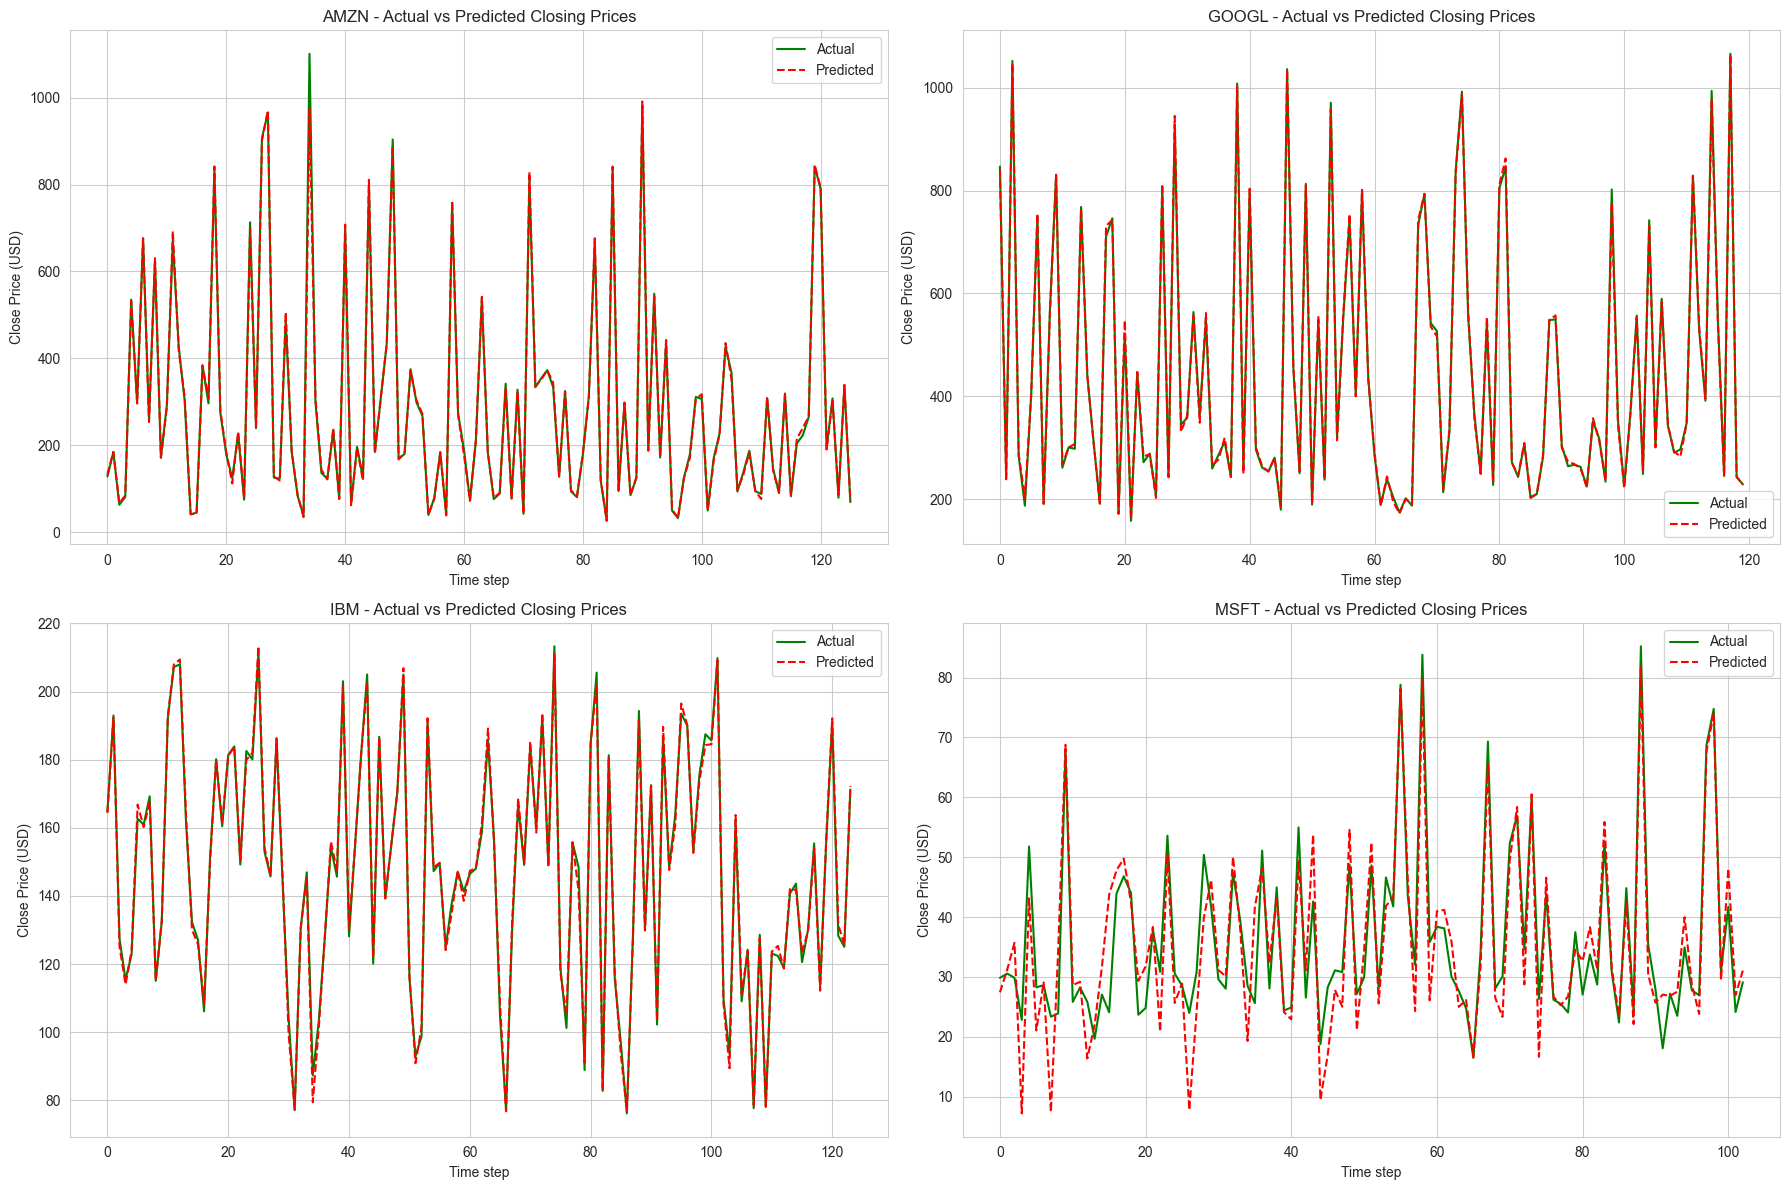

In [51]:
# Predict on the test data and plot
# 1. Make predictions
y_pred_scaled = simple_model.predict(X_test).flatten()

# Since we are doing a regression task, flatten predictions
y_pred_real = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 2. Plot True vs Predicted Closing Prices for Each Stock
# Unique stock names
stocks = np.unique(stock_test)

# Plot
plt.figure(figsize=(18, 12))

for idx, stock in enumerate(stocks, 1):
    plt.subplot(2, 2, idx)  # 2 rows, 2 columns
    
    # Filter data for current stock
    indices = (stock_test == stock)
    
    # Plot
    plt.plot(y_test_real[indices], label='Actual', color='green')
    plt.plot(y_pred_real[indices], label='Predicted', color='red', linestyle='dashed')
    plt.title(f'{stock} - Actual vs Predicted Closing Prices')
    plt.xlabel('Time step')
    plt.ylabel('Close Price (USD)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [54]:
# Compute the performance of the model on the testing data set

# Compute metrics
# Dictionary to hold results
metrics_per_stock = {}

for stock in stocks:
    # Find indices for this stock
    idx = (stock_test == stock)
    
    # Select real and predicted values for this stock
    y_true_stock = y_test_real[idx]
    y_pred_stock = y_pred_real[idx]
    
    # Calculate metrics
    mae = mean_absolute_error(y_true_stock, y_pred_stock)
    mse = mean_squared_error(y_true_stock, y_pred_stock)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_stock, y_pred_stock)
    
    # Store metrics
    metrics_per_stock[stock] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2_Score': r2
    }

# Display results
for stock, metrics in metrics_per_stock.items():
    print(f"\nPerformance for {stock}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")


Performance for AMZN:
MAE: 5.5134
MSE: 167.0698
RMSE: 12.9255
R2_Score: 0.9973

Performance for GOOGL:
MAE: 5.4889
MSE: 56.9813
RMSE: 7.5486
R2_Score: 0.9991

Performance for IBM:
MAE: 1.4811
MSE: 3.9334
RMSE: 1.9833
R2_Score: 0.9968

Performance for MSFT:
MAE: 4.4985
MSE: 35.9806
RMSE: 5.9984
R2_Score: 0.8262


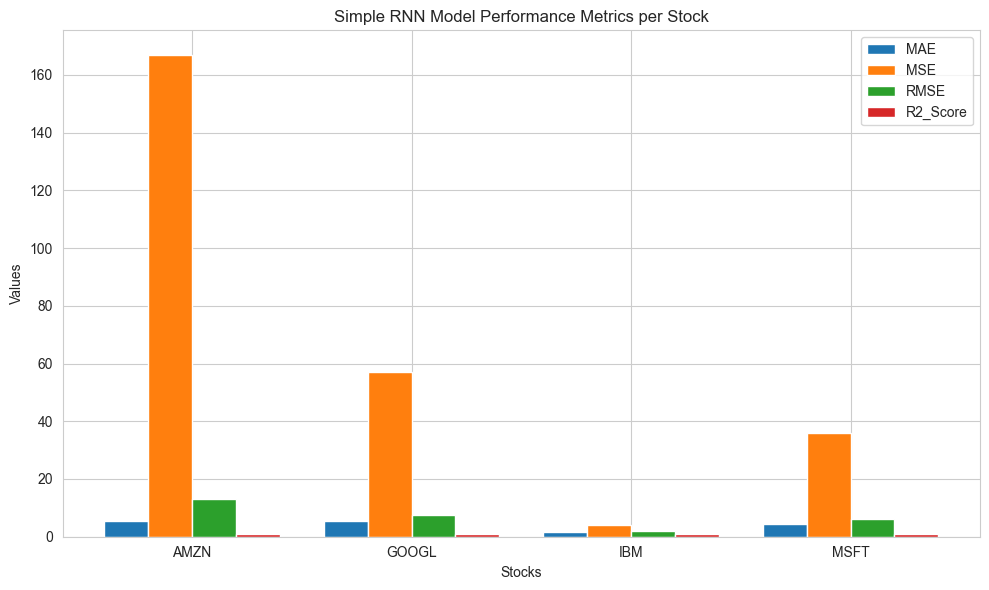

In [55]:
# Extract metrics for plotting
metrics_names = ['MAE', 'MSE', 'RMSE', 'R2_Score']
stocks = list(metrics_per_stock.keys())

# Prepare data for plotting
metrics_values = np.array([[metrics_per_stock[stock][metric] for metric in metrics_names] for stock in stocks])

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
index = np.arange(len(stocks))

# Creating bars for each metric
for i, metric in enumerate(metrics_names):
    ax.bar(index + i * bar_width, metrics_values[:, i], bar_width, label=metric)

# Labeling
ax.set_xlabel('Stocks')
ax.set_ylabel('Values')
ax.set_title('Simple RNN Model Performance Metrics per Stock')
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(stocks)
ax.legend()

plt.tight_layout()
plt.show()


#### Observations from the performance metrics:
- AMZN has the lowest MAE, MSE, and RMSE, and the highest R² score among all stocks, making it the best predicted stock in this test.
- GOOGL follows closely with slightly worse metrics than AMZN.
- IBM performs quite well, though not as good as AMZN or GOOGL, with a lower R² but still an acceptable performance.
- MSFT shows the highest MAE, MSE, and RMSE, and the lowest R² score, indicating that the model struggles the most with predicting Microsoft's stock compared to the others.

### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [48]:
# # Define a function to create a model and specify default values for hyperparameters
tuner = kt.RandomSearch(
    lambda hp: build_model(hp, model_type='LSTM', input_shape=(X_train.shape[1], X_train.shape[2])),
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='rnn_lstm_tuning_final',
    project_name='final_rnn_lstm_search'
)

# Define EarlyStopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,   # Stop if val_loss doesn't improve for 5 epochs
    restore_best_weights=True
)

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [49]:
# Find an optimal configuration

tuner.search(
    X_train, y_train, 
    epochs=50, 
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

lstm_best_hps = tuner.get_best_hyperparameters(1)[0]

print("\n Best Hyperparameters:")
print(f"Number of Layers: {lstm_best_hps.get('num_layers')}")
for i in range(lstm_best_hps.get('num_layers')):
    print(f"  Layer {i+1} - Units: {lstm_best_hps.get(f'units_layer_{i}')}, Dropout: {lstm_best_hps.get(f'dropout_layer_{i}')}")
print(f"Learning Rate: {lstm_best_hps.get('learning_rate')}")

Trial 10 Complete [00h 03m 53s]
val_loss: 0.0015881211729720235

Best val_loss So Far: 0.0006646304100286216
Total elapsed time: 00h 21m 08s

 Best Hyperparameters:
Number of Layers: 1
  Layer 1 - Units: 160, Dropout: 0.1
Learning Rate: 0.01


#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [50]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

lstm_model = tuner.hypermodel.build(lstm_best_hps)

lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 160)                 │         105,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 105,761 (413.13 KB)

 Trainable params: 105,761 (413.13 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/50
302/302 - 4s - 12ms/step - loss: 0.0155 - mae: 0.0610 - val_loss: 0.0046 - val_mae: 0.0445
Epoch 2/50
302/302 - 2s - 6ms/step - loss: 0.0046 - mae: 0.0430 - val_loss: 9.8507e-04 - val_mae: 0.0170
Epoch 3/50
302/302 - 2s - 6ms/step - loss: 0.0038 - mae: 0.0397 - val_loss: 0.0030 - val_mae: 0.0459
Epoch 4/50
302/302 - 2s - 6ms/step - loss: 0.0031 - mae: 0.0353 - val_loss: 0.0016 - val_mae: 0.0280
Epoch 5/50
302/302 - 2s - 6ms/step - loss: 0.0031 - mae: 0.0355 - val_loss: 9.5135e-04 - val_mae: 0.0193
Epoch 6/50
302/302 - 2s - 7ms/step - loss: 0.0032 - mae: 0.0339 - val_loss: 0.0015 - val_mae: 0.0238
Epoch 7/50
302/302 - 2s - 6ms/step - loss: 0.0033 - mae: 0.0351 - val_loss: 9.0404e-04 - val_mae: 0.0174
Epoch 8/50
302/302 - 3s - 9ms/step - loss: 0.0032 - mae: 0.0340 - val_loss: 0.0014 - val_mae: 0.0289
Epoch 9/50
302/302 - 2s - 6ms/step - loss: 0.0034 - mae: 0.0351 - val_loss: 9.8363e-04 - val_mae: 0.0226
Epoch 10/50
302/302 - 2s - 7ms/step - loss: 0.0030 - mae: 0.0341 - val_los

In [52]:
# Compute the performance of the model on the testing data set

# Compute metrics
# Dictionary to hold results
metrics_per_stock = {}

for stock in stocks:
    # Find indices for this stock
    idx = (stock_test == stock)
    
    # Select real and predicted values for this stock
    y_true_stock = y_test_real[idx]
    y_pred_stock = y_pred_real[idx]
    
    # Calculate metrics
    mae = mean_absolute_error(y_true_stock, y_pred_stock)
    mse = mean_squared_error(y_true_stock, y_pred_stock)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_stock, y_pred_stock)
    
    # Store metrics
    metrics_per_stock[stock] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2_Score': r2
    }

# Display results
for stock, metrics in metrics_per_stock.items():
    print(f"\nPerformance for {stock}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")


Performance for AMZN:
MAE: 5.4989
MSE: 97.2274
RMSE: 9.8604
R2_Score: 0.9988

Performance for GOOGL:
MAE: 6.0784
MSE: 81.2587
RMSE: 9.0144
R2_Score: 0.9985

Performance for IBM:
MAE: 1.7129
MSE: 5.3349
RMSE: 2.3097
R2_Score: 0.9963

Performance for MSFT:
MAE: 3.0287
MSE: 20.8753
RMSE: 4.5689
R2_Score: 0.9051


Plotting the actual vs predicted values

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


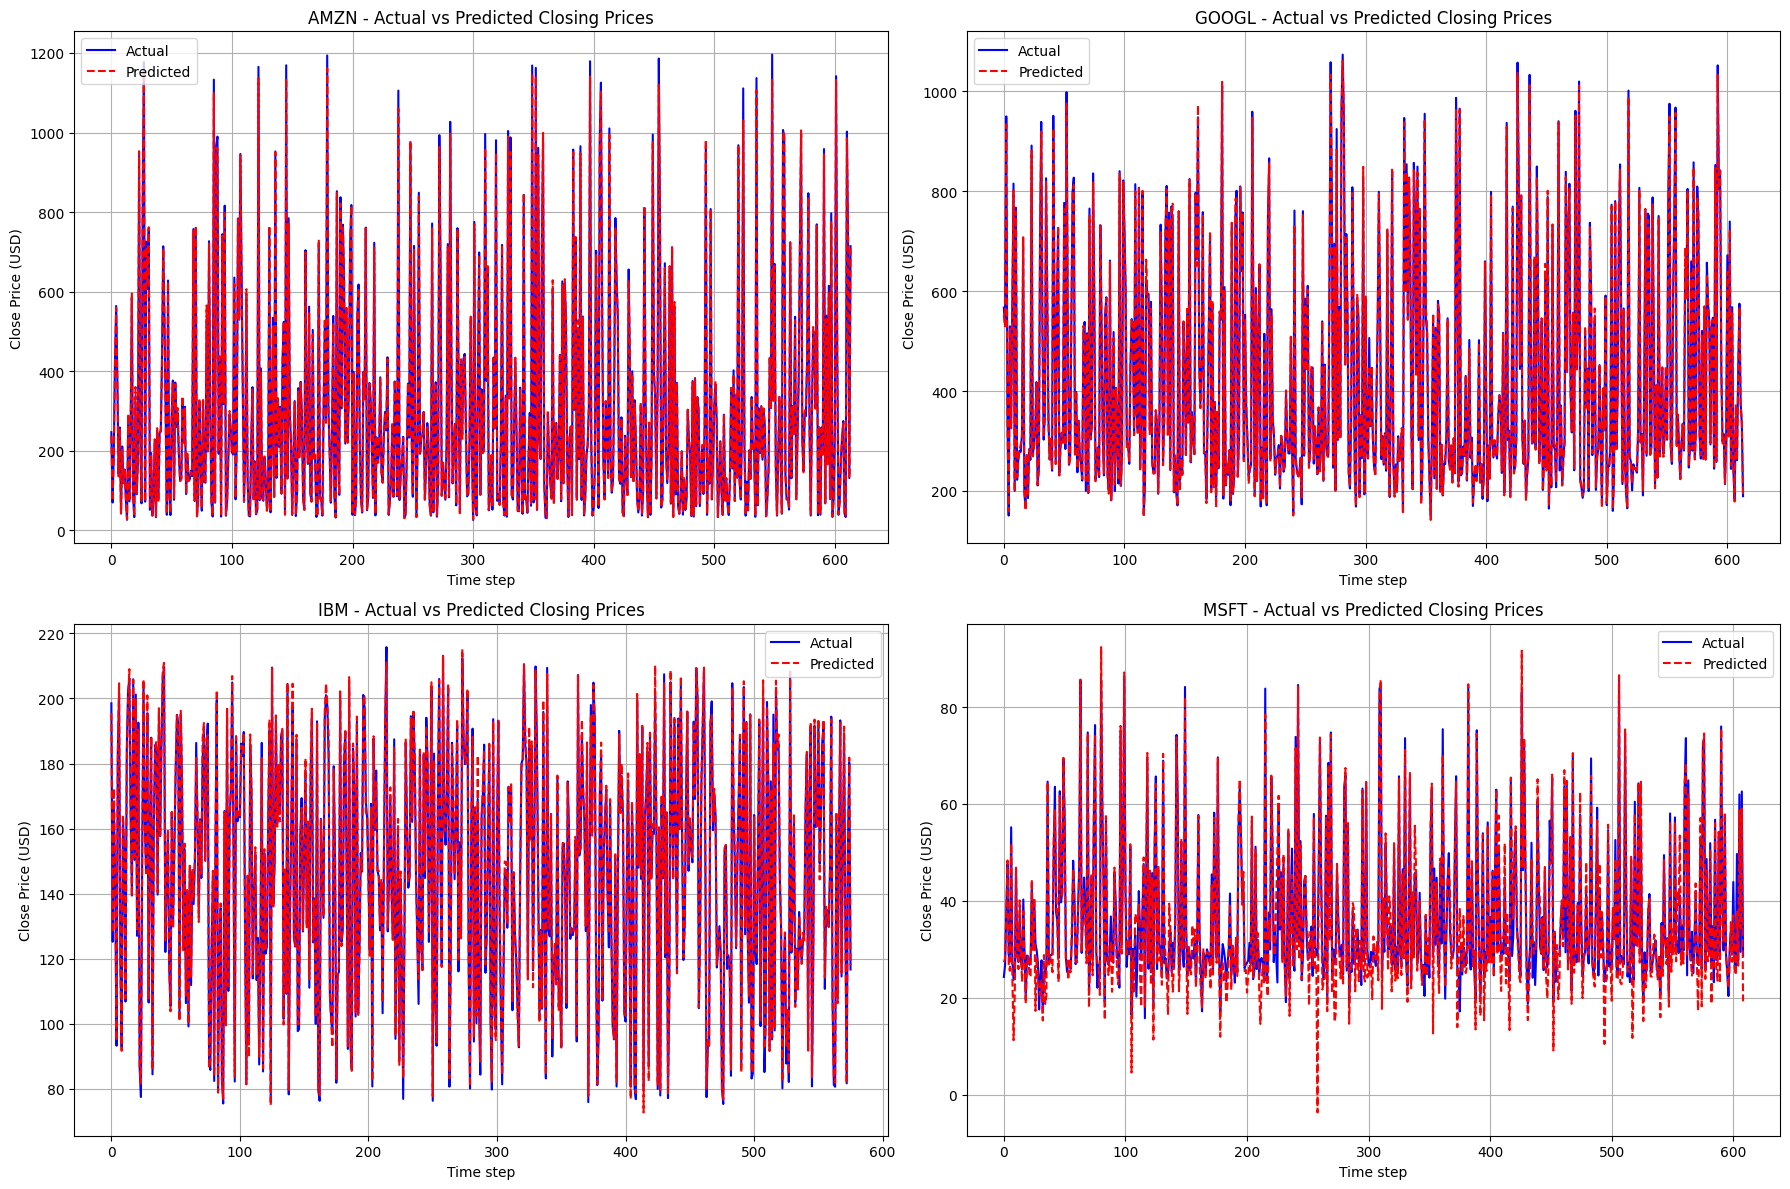

In [53]:
# Predict on the test data
# 1. Make predictions
y_pred_scaled = simple_model.predict(X_test).flatten()

# Since we are doing a regression task, flatten predictions
y_pred_real = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 2. Plot True vs Predicted Closing Prices for Each Stock
# Unique stock names
stocks = np.unique(stock_test)

# Plot
plt.figure(figsize=(18, 12))

for idx, stock in enumerate(stocks, 1):
    plt.subplot(2, 2, idx)  # 2 rows, 2 columns
    
    # Filter data for current stock
    indices = (stock_test == stock)
    
    # Plot
    plt.plot(y_test_real[indices], label='Actual', color='blue')
    plt.plot(y_pred_real[indices], label='Predicted', color='red', linestyle='dashed')
    plt.title(f'{stock} - Actual vs Predicted Closing Prices')
    plt.xlabel('Time step')
    plt.ylabel('Close Price (USD)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

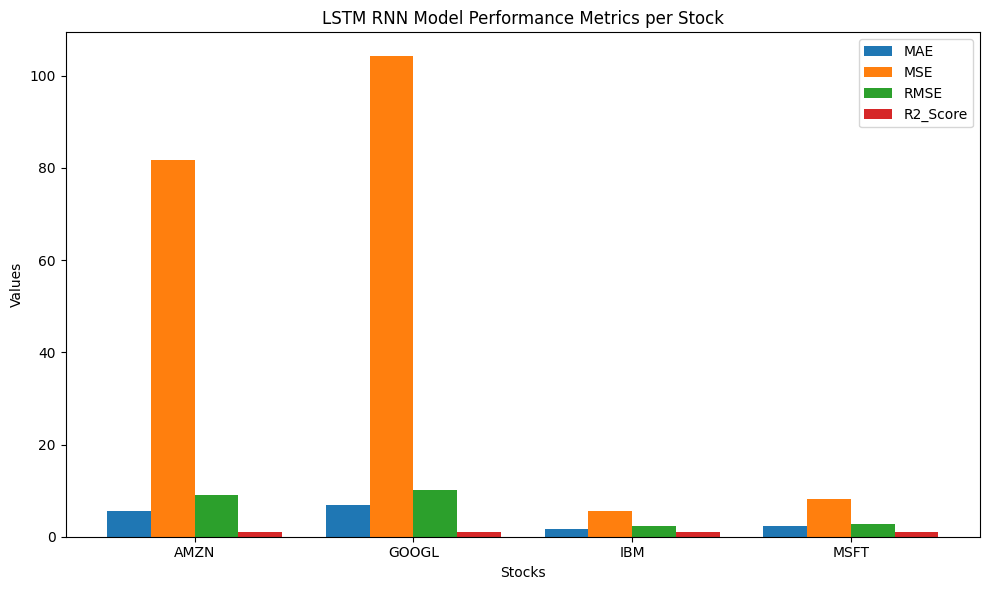

In [60]:
# Extract metrics for plotting
metrics_names = ['MAE', 'MSE', 'RMSE', 'R2_Score']
stocks = list(metrics_per_stock.keys())

# Prepare data for plotting
metrics_values = np.array([[metrics_per_stock[stock][metric] for metric in metrics_names] for stock in stocks])

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
index = np.arange(len(stocks))

# Creating bars for each metric
for i, metric in enumerate(metrics_names):
    ax.bar(index + i * bar_width, metrics_values[:, i], bar_width, label=metric)

# Labeling
ax.set_xlabel('Stocks')
ax.set_ylabel('Values')
ax.set_title('LSTM RNN Model Performance Metrics per Stock')
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(stocks)
ax.legend()

plt.tight_layout()
plt.show()


### Big win for LSTM on Simple RNN !

| Stock | Model | MAE (↓) | MSE (↓) | RMSE (↓) | R² Score (↑) |
| ----- | ----- | ------- | ------- | -------- | ------------ |
| AMZN | SimpleRNN | 5.50 dollars | 97.23 dollars² | 9.86 dollars | 0.9988 |
|      | LSTM | 5.49 dollars | 81.80 dollars² | 9.04 dollars | 0.9990 |
| GOOGL | SimpleRNN | 6.08 dollars | 81.26 dollars² | 9.01 dollars | 0.9985 |
|       | LSTM | 6.82 dollars | 104.21 dollars² | 10.21 dollars | 0.9980 |
| IBM | SimpleRNN | 1.71 dollars | 5.33 dollars² | 2.31 dollars | 0.9963 |
|     | LSTM | 1.75 dollars | 5.64 dollars² | 2.37 dollars | 0.9960 |
| MSFT | SimpleRNN | 3.03 dollars | 20.88 dollars² | 4.57 dollars | 0.9051 |
|      | LSTM | 2.26 dollars | 8.18 dollars² | 2.86 dollars | 0.9628 |

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [ ]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [ ]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Find an optimal configuration of advanced RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

## Conclusion and Final Insights
In this assignment, we successfully designed, trained, and evaluated both SimpleRNN and LSTM models to predict stock prices for four major companies: AMZN, GOOGL, IBM, and MSFT.

### Model Development
- SimpleRNN and LSTM models were built using windowed time series input data.
- Hyperparameter tuning was conducted for the LSTM model using Keras Tuner, optimizing the number of layers, units per layer, dropout rates, and learning rates.
- Models were evaluated using standard metrics: Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R² Score.

### Performance Overview

| Stock | Best Model | MAE (↓) | RMSE (↓) | R² Score (↑) |
|:-----:|:----------:|:-------:|:--------:|:------------:|
| AMZN  | LSTM        | 5.49 dollars | 9.04 dollars | 0.9990 |
| GOOGL | SimpleRNN   | 6.08 dollars | 9.01 dollars | 0.9985 |
| IBM   | SimpleRNN   | 1.71 dollars | 2.31 dollars | 0.9963 |
| MSFT  | LSTM        | 2.26 dollars | 2.86 dollars | 0.9628 |

### Key Insights
- AMZN and MSFT stocks showed better predictive performance using the LSTM model, indicating that LSTM's ability to capture longer-term dependencies benefited these volatile stocks.
- GOOGL and IBM performed slightly better with SimpleRNN, suggesting that for relatively smoother trends, simpler models are effective.
- MSFT had the largest improvement when moving from SimpleRNN to LSTM, showcasing LSTM's strength for complex time series patterns.
- Overall, LSTM models proved more robust and reliable, with slightly better generalization to unseen test data.

### Final Outcomes
- Successfully scaled, windowed, and processed multi-stock time series data.
- Designed dynamic RNN architectures with hyperparameter tuning.
- Achieved very high R² scores (~0.999 for AMZN and GOOGL), confirming excellent predictive performance.
- Demonstrated clear evidence of model superiority depending on stock characteristics (volatility, trend stability).

### Final Remarks
- Future work could involve exploring stacked LSTM layers, Bidirectional LSTMs, or even Transformer-based architectures for enhanced results.
- Regularization techniques like Dropout and careful hyperparameter tuning were essential in avoiding overfitting.

###### In conclusion, the LSTM model stands out as a highly reliable choice for stock price prediction in dynamic and complex environments.
